In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
sys.path.insert(1, "/home/ec753/Projects/NST_experiment/utils/")
import HH

In [2]:
sim_length = 1_000_000
e_i=5
i_i=15
e_w=0.2
i_w=0.5
e_t=2
i_t=6

sp = HH.StimParams(e_i=e_i, i_i=i_i, e_w=e_w, i_w=i_w, e_t=e_t, i_t=i_t)
df, spikes, stim_times = HH.run_poisson_sim(sim_length=sim_length, stim_params=sp)

estims = stim_times[0]
istims = stim_times[1]

In [3]:
o_history = pd.DataFrame(
    {
        'v': [12.700157],
        'm': 0.656062,
        'n': 0.437152,
        'h': 0.395021
    }
)

## reconstruct after spike

In [4]:
reconstruct_duration = 100
n = 1000 # number of spikes to reconstruct
viable_spikes = [spike for spike in spikes if spike < sim_length - reconstruct_duration]
spike_inds = np.random.choice(np.arange(0, len(viable_spikes)), n, replace=False)

reconstruction_events = []
reconstructed_dfs = []
reconstructed_spikes = []

print('______PROGRESS______')
progress = 0.0
for i, ind in enumerate(spike_inds):
    starting_spike = spikes[ind]
    subsequent_estims = [
        ('e', estim) for estim in estims if 
        (estim > starting_spike) and (estim < starting_spike + reconstruct_duration)
    ]
    subsequent_istims = [
        ('i', istim) for istim in istims if 
        (istim > starting_spike) and (istim < starting_spike + reconstruct_duration)
    ]
    events = [('o',0)]+[(stim_type, stim_time-starting_spike) for stim_type, stim_time in subsequent_estims+subsequent_istims]
    # order events
    events.sort(key=lambda x:x[1])
    
    re_df, re_spikes = HH.run_event_sim(
        events, 
        history=o_history, 
        positive_sim_duration=reconstruct_duration,
        e_w=e_w, i_w=i_w, e_t=e_t, i_t=i_t,
        plot=True
    )
    reconstruction_events.append(events)
    reconstructed_dfs.append(re_df)
    reconstructed_spikes.append(re_spikes)
    
    if i/n > progress:
        print('=',end='')
        progress+=0.05

______PROGRESS______

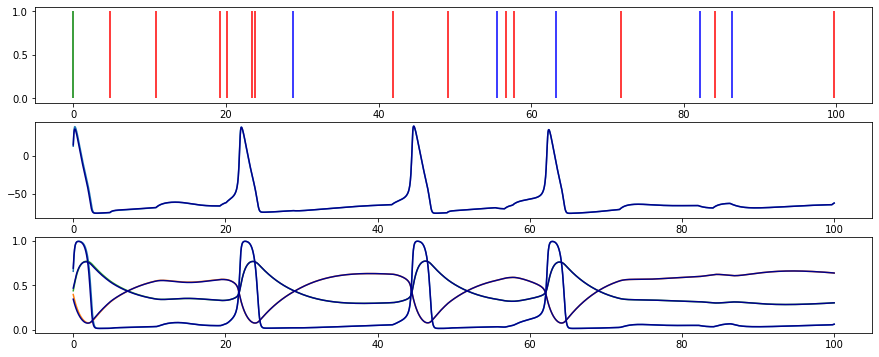

In [5]:
ind = 0
fig, axes = plt.subplots(3,1, figsize=(15,6))
# input stimuli
axes[0].vlines([event[1] for event in reconstruction_events[ind]], 0, 1, colors=[HH.event_type2color(event[0]) for event in reconstruction_events[ind]])
# reconstructed Vm
axes[1].plot(reconstructed_dfs[ind]['t'], reconstructed_dfs[ind]['v'])
# ground truth Vm
start_spike = spikes[spike_inds[ind]]
start_ind = np.where(df['t'] >=start_spike)[0][0]-1
stop_ind = start_ind + 40*reconstruct_duration + 1
#ground_truth_slice = df[(df['t']>=start_spike) & (df['t']<=start_spike+100)]
ground_truth_slice = df.iloc[start_ind:stop_ind,:]
axes[1].plot(ground_truth_slice['t']-start_spike, ground_truth_slice['v'], c='darkblue')
# reconstructed state variables
axes[2].plot(reconstructed_dfs[ind]['t'], reconstructed_dfs[ind]['m'])
axes[2].plot(reconstructed_dfs[ind]['t'], reconstructed_dfs[ind]['h'])
axes[2].plot(reconstructed_dfs[ind]['t'], reconstructed_dfs[ind]['n'])
# ground truth state variables
axes[2].plot(ground_truth_slice['t']-start_spike, ground_truth_slice['m'], c='darkblue')
axes[2].plot(ground_truth_slice['t']-start_spike, ground_truth_slice['h'], c='darkblue')
axes[2].plot(ground_truth_slice['t']-start_spike, ground_truth_slice['n'], c='darkblue')
plt.show()

## calculate the error as a function of time

______PROGRESS______

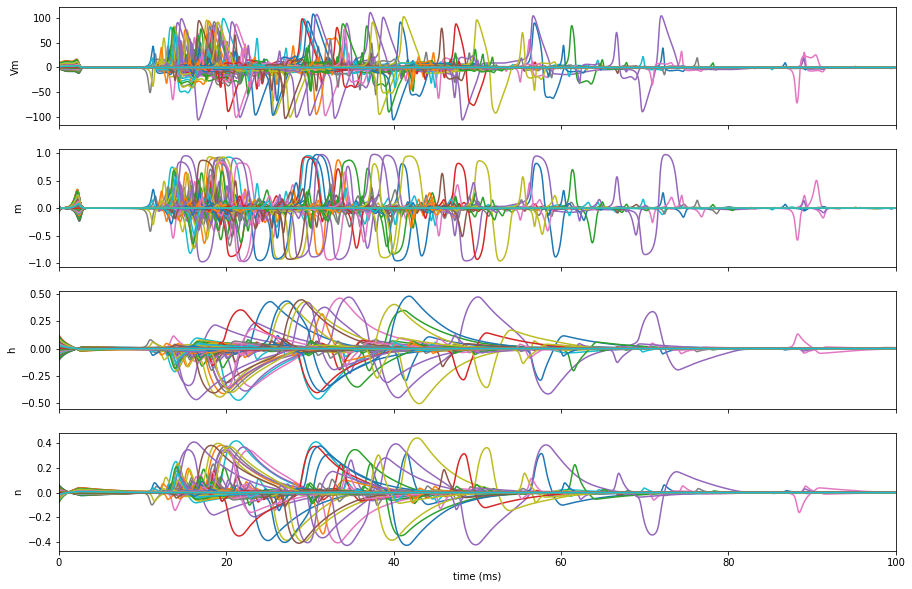

In [6]:
fig, axes = plt.subplots(4,1, figsize=(15,10), sharex=True)

v_errors = []
m_errors = []
h_errors = []
n_errors = []

print('______PROGRESS______')
progress = 0.0
for ind in range(n):
    # input stimuli
    # reconstructed Vm
    reconstructed_slice = reconstructed_dfs[ind]
    # ground truth Vm
    start_spike = spikes[spike_inds[ind]]
    start_ind = np.where(df['t'] >=start_spike)[0][0]-1
    stop_ind = start_ind + 40*reconstruct_duration + 1
    ground_truth_slice = df.iloc[start_ind:stop_ind,:]
    _v_errors = np.array(reconstructed_slice['v']) - np.array(ground_truth_slice['v'])
    _m_errors = np.array(reconstructed_slice['m']) - np.array(ground_truth_slice['m'])
    _h_errors = np.array(reconstructed_slice['h']) - np.array(ground_truth_slice['h'])
    _n_errors = np.array(reconstructed_slice['n']) - np.array(ground_truth_slice['n'])
    
    axes[0].plot(reconstructed_slice['t'], _v_errors)
    axes[1].plot(reconstructed_slice['t'], _m_errors)
    axes[2].plot(reconstructed_slice['t'], _h_errors)
    axes[3].plot(reconstructed_slice['t'], _n_errors)
    
    v_errors.append(_v_errors)
    m_errors.append(_m_errors)
    h_errors.append(_h_errors)
    n_errors.append(_n_errors)
    
    if ind/n > progress:
        print('=',end='')
        progress+=0.05
    
axes[0].set_ylabel('Vm')
axes[1].set_ylabel('m')
axes[2].set_ylabel('h')
axes[3].set_ylabel('n')
axes[-1].set_xlabel('time (ms)')
axes[-1].set_xlim(0, reconstruct_duration)
plt.show()

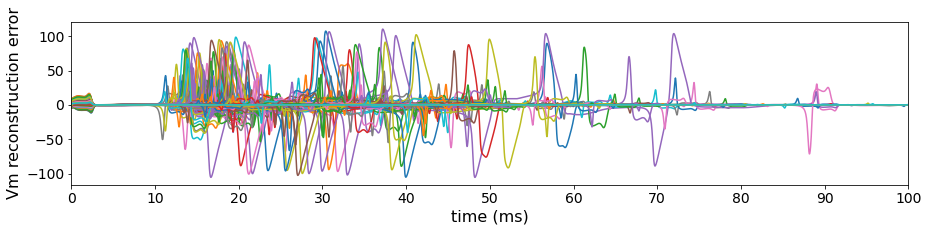

In [32]:
plt.figure(figsize=(15,3))
for errors in v_errors:
    plt.plot(reconstructed_slice['t'], errors)
plt.xlabel('time (ms)', fontsize=16)
plt.ylabel('Vm reconstruction error', fontsize=16)
plt.xlim(0,reconstruct_duration)

plt.yticks(fontsize=14)
plt.xticks(np.arange(0,101,10), fontsize=14)
plt.show()

In [8]:
_v_errors = np.array(v_errors)
_m_errors = np.array(m_errors)
_n_errors = np.array(n_errors)
_h_errors = np.array(h_errors)

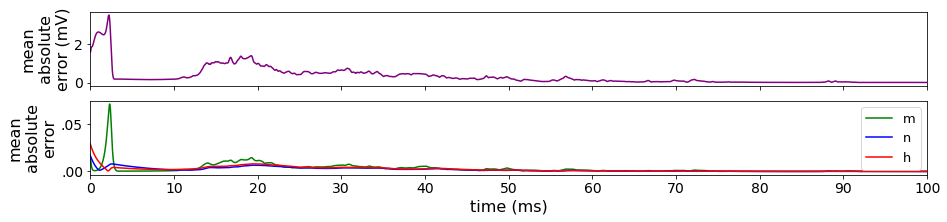

In [30]:
fig, axes = plt.subplots(2,1, figsize=(15,3), sharex=True)

axes[0].plot(reconstructed_slice['t'], np.mean(np.abs(_v_errors), axis=0), c='purple')
axes[1].plot(reconstructed_slice['t'], np.mean(np.abs(_m_errors), axis=0), c='green')
axes[1].plot(reconstructed_slice['t'], np.mean(np.abs(_n_errors), axis=0), c='blue')
axes[1].plot(reconstructed_slice['t'], np.mean(np.abs(_h_errors), axis=0), c='red')
axes[1].set_xlim(0,reconstruct_duration)
axes[1].set_ylabel('mean\nabsolute\nerror', fontsize=16)
axes[0].set_ylabel('mean\nabsolute\nerror (mV)', fontsize=16)
axes[-1].set_xlabel('time (ms)', fontsize=16)
axes[1].legend(['m','n','h'], fontsize=13)

axes[0].set_yticks([0,2])
axes[0].set_yticklabels([0,2], fontsize=14)

axes[1].set_yticks([.00,.05])
axes[1].set_yticklabels(['.00','.05'], fontsize=14)

axes[1].set_xticks(np.arange(0,101,10))
axes[1].set_xticklabels(np.arange(0,101,10), fontsize=14)
#axes[0].set_title('state variable reconstruction mean absolute error')
plt.show()

In [24]:
np.arange(0,101,10)

array([  0,  10,  20,  30,  40,  50,  60,  70,  80,  90, 100])

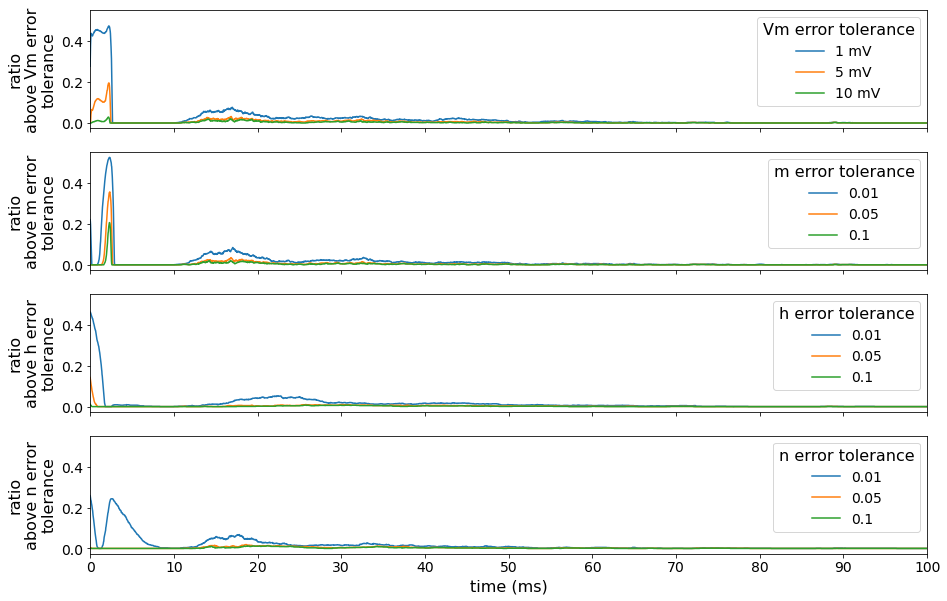

In [27]:
v_error_tolerances = [1,5,10]
statevar_error_tolerances = [.01, .05, .1]
bins = np.arange(0,4001, 1)

fig, axes = plt.subplots(4,1, figsize=(15,10), sharex=True, sharey=True)
# Vm
for error_tolerance in v_error_tolerances:
    
    counts, bins = np.histogram(np.where(_v_errors>error_tolerance)[1], bins=bins)
    ratios = counts/n
    axes[0].plot(ratios)
axes[0].legend([str(x)+' mV' for x in v_error_tolerances], title='Vm error tolerance', fontsize=14, title_fontsize=16)
axes[0].set_ylabel('ratio\nabove Vm error\ntolerance', fontsize=16)
# m
for error_tolerance in statevar_error_tolerances:
    counts, bins = np.histogram(np.where(_m_errors>error_tolerance)[1], bins=bins)
    ratios = counts/n
    axes[1].plot(ratios)
axes[1].legend(statevar_error_tolerances, title='m error tolerance', fontsize=14, title_fontsize=16)
axes[1].set_ylabel('ratio\nabove m error\ntolerance', fontsize=16)
# h
for error_tolerance in statevar_error_tolerances:
    counts, bins = np.histogram(np.where(_h_errors>error_tolerance)[1], bins=bins)
    ratios = counts/n
    axes[2].plot(ratios)
axes[2].legend(statevar_error_tolerances, title='h error tolerance', fontsize=14, title_fontsize=16)
axes[2].set_ylabel('ratio\nabove h error\ntolerance', fontsize=16)
# n
for error_tolerance in statevar_error_tolerances:
    counts, bins = np.histogram(np.where(_n_errors>error_tolerance)[1], bins=bins)
    ratios = counts/n
    axes[3].plot(ratios)
axes[3].legend(statevar_error_tolerances, title='n error tolerance', fontsize=14, title_fontsize=16)
axes[3].set_ylabel('ratio\nabove n error\ntolerance', fontsize=16)

axes[-1].set_xlim(0,40*reconstruct_duration)
axes[-1].set_xticks(np.arange(0,(40*reconstruct_duration)+1, 400))
axes[-1].set_xticklabels(np.arange(0,reconstruct_duration+1, 10), fontsize=14)
axes[-1].set_xlabel('time (ms)', fontsize=16)


for ax in axes:
    ax.set_yticks([0.0,0.2,0.4])
    ax.set_yticklabels([0.0,0.2,0.4], fontsize=14)

plt.show()

In [11]:
# TODO, make a log y scale version as well

# probably the error tolerance as the paper figure and the 

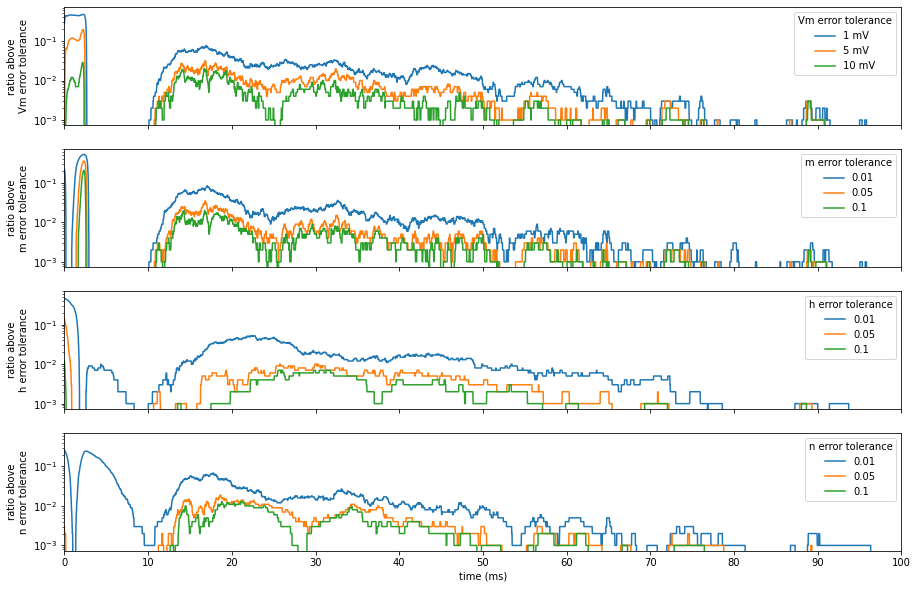

In [12]:
v_error_tolerances = [1,5,10]
statevar_error_tolerances = [.01, .05, .1]
bins = np.arange(0,4001, 1)

fig, axes = plt.subplots(4,1, figsize=(15,10), sharex=True, sharey=True)
# Vm
for error_tolerance in v_error_tolerances:
    
    counts, bins = np.histogram(np.where(_v_errors>error_tolerance)[1], bins=bins)
    ratios = counts/n 
    axes[0].plot(ratios)
axes[0].set_yscale('log')
axes[0].legend([str(x)+' mV' for x in v_error_tolerances], title='Vm error tolerance')
axes[0].set_ylabel('ratio above\nVm error tolerance')
# m
for error_tolerance in statevar_error_tolerances:
    counts, bins = np.histogram(np.where(_m_errors>error_tolerance)[1], bins=bins)
    ratios = counts/n
    axes[1].plot(ratios)
axes[1].set_yscale('log')
axes[1].legend(statevar_error_tolerances, title='m error tolerance')
axes[1].set_ylabel('ratio above\nm error tolerance')
# h
for error_tolerance in statevar_error_tolerances:
    counts, bins = np.histogram(np.where(_h_errors>error_tolerance)[1], bins=bins)
    ratios = counts/n
    axes[2].plot(ratios)
axes[2].set_yscale('log')
axes[2].legend(statevar_error_tolerances, title='h error tolerance')
axes[2].set_ylabel('ratio above\nh error tolerance')
# n
for error_tolerance in statevar_error_tolerances:
    counts, bins = np.histogram(np.where(_n_errors>error_tolerance)[1], bins=bins)
    ratios = counts/n
    axes[3].plot(ratios)
axes[3].set_yscale('log')
axes[3].legend(statevar_error_tolerances, title='n error tolerance')
axes[3].set_ylabel('ratio above\nn error tolerance')

axes[-1].set_xlim(0,40*reconstruct_duration)
axes[-1].set_xticks(np.arange(0,(40*reconstruct_duration)+1, 400))
axes[-1].set_xticklabels(np.arange(0,reconstruct_duration+1, 10))
axes[-1].set_xlabel('time (ms)')
plt.show()

In [13]:
counts

array([0, 0, 0, ..., 0, 0, 0])